In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
# Пути до файлов
path_to_file_1 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-pjatakova/files/assessments.csv'
path_to_file_2 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-pjatakova/files/courses.csv'
path_to_file_3 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-pjatakova/files/studentAssessment.csv'
path_to_file_4 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-pjatakova/files/studentRegistration.csv'

<strong>assessments_df</strong> — этот датафрейм содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).  
<strong>*Колонки*</strong>:
- code_module — идентификационный код предмета.
- code_presentation — семестр (Идентификационный код).
- id_assessment — тест (Идентификационный номер ассессмента).
- assessment_type — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).
- date — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).
- weight — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

<strong>courses_df</strong> — датафрейм содержит список предметов по семестрам.  
<strong>*Колонки*</strong>:
- code_module — предмет (идентификационный код).
- code_presentation — семестр (идентификационный код).

<strong>std_assessment_df</strong> — этот датафрейм содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.  
<strong>*Колонки*</strong>:
- id_assessment — тест (идентификационный номер).
- id_student — идентификационный номер студента.
- date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.
- is_banked — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).
- score — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

<strong>std_registr_df</strong> - этот датафрейм содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.  
<strong>*Колонки*</strong>:
- code_module — предмет (идентификационный код).
- code_presentation — семестр (идентификационный код)
- id_student — идентификационный номер студента.
- date_registration — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).
- date_unregistration — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

In [3]:
# Грузим данные
assessments_df = pd.read_csv(path_to_file_1)
courses_df = pd.read_csv(path_to_file_2)
std_assessment_df = pd.read_csv(path_to_file_3)
std_registr_df = pd.read_csv(path_to_file_4)

<h3> START. Проведем предварительное исследование данных и сформулируем, что должно считаться курсом

<h4>1. assessments_df - содержит информацию об оценках в тесте

In [4]:
assessments_df

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
...,...,...,...,...,...,...
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


In [5]:
# Посчитаем количество предметов
assessments_df.code_module.nunique()

7

In [6]:
# Определим, что за предметы и сколько раз они встречаются
assessments_df.code_module.value_counts()

FFF    52
BBB    42
DDD    35
GGG    30
CCC    20
EEE    15
AAA    12
Name: code_module, dtype: int64

In [7]:
# Выведем, какие есть семестры и сколько раз они встречаются
assessments_df.code_presentation.value_counts()

2014B    57
2014J    57
2013J    53
2013B    39
Name: code_presentation, dtype: int64

In [8]:
assessments_df.shape

(206, 6)

In [9]:
assessments_df.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object

<h4>2. courses_df - содержит список предметов по семестрам

In [10]:
courses_df.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [11]:
# Посмотрим на длительность каждого предмета в днях
for_barplot = courses_df.groupby('code_module', as_index=False).agg({'module_presentation_length': 'sum'})
for_barplot

,code_module,module_presentation_length
0,AAA,537
1,BBB,1004
2,CCC,510
3,DDD,1004
4,EEE,778
5,FFF,1018
6,GGG,771


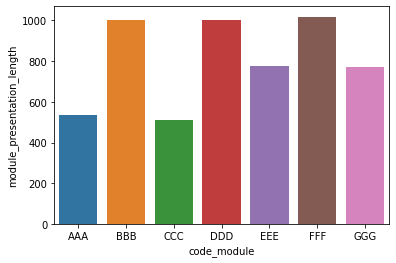

In [12]:
# Построим график
sns.barplot(x='code_module', y='module_presentation_length', data = for_barplot)

Видим, что самыми длительными предметами являются - BBB, DDD, FFF. Самые краткосрочные предметы - AAA, CCC

In [13]:
courses_df.shape

(22, 3)

In [14]:
courses_df.dtypes

code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object

<h4>3. std_assessment_df — содержит результаты тестов студентов

In [15]:
std_assessment_df.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [16]:
std_assessment_df.shape

(173912, 5)

In [17]:
std_assessment_df.dtypes

id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object

In [18]:
# Посмотрим на средние баллы сдачи для каждого теста
for_barplot_1 = std_assessment_df.groupby('id_assessment', as_index=False)\
    .agg({'score': 'mean'})\
    .rename(columns={'score': 'mean_score'})
for_barplot_1

,id_assessment,mean_score
0,1752,70.307263
1,1753,66.801170
2,1754,70.439394
3,1755,70.567657
4,1756,69.127517
...,...,...
183,37439,86.071429
184,37440,84.308977
185,37441,91.923890
186,37442,75.480769


In [19]:
# Посмотрим, какой тест имеет наиболее высокие средние оценки - тест №15015
for_barplot_1.mean_score.max()
for_barplot_1.query('mean_score == 93.83301707779886')

,id_assessment,mean_score
38,15015,93.833017


In [20]:
# Посмотрим, какой тест имеет наиболее низкие средние оценки - тест №25340
for_barplot_1.mean_score.min()
for_barplot_1.query('mean_score == 56.35382059800664')

,id_assessment,mean_score
72,25340,56.353821


<h4> 4. std_registr_df — содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре

In [21]:
std_registr_df.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [22]:
std_registr_df.shape

(32593, 5)

In [23]:
std_registr_df.dtypes

code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object

<strong>Что будем считать за курс?</strong>  
По логике, курсом является прохождение определенного <strong>*УНИКАЛЬНОГО*</strong> предмета (code_module), результатом освоения которого является экзамен (Exam) в типе теста (assessment_type), поскольку экзамены имеют вес 100% и соответственно значительную степень влияния на итоговые результаты курса.

Как было выявлено, уникальных предметов у нас 7:
- FFF
- BBB
- DDD
- GGG
- CCC
- EEE
- AAA

Используя таблицу <strong>assessments_df</strong> посмотрим, у каких из этих предметов формой контроля является <strong>Экзамен</strong>.  
Видим, что у всех 7 предметов - формой контроля является экзамен. При том, экзамен по каждому предмету проходит в каждом семестре  
Предметов у нас 7, но у них разная продолжительность (соответственно, разное количество семестров в курсе) и поскольку мы определили, что на понятие курса влияет наличие экзамена, то курсов у нас 24 (например, по предмету BBB 4 экзамена за 4 семестра и, следовательно, 4 курса)

In [24]:
assessments_df_Exams = assessments_df.query("assessment_type == 'Exam'")

In [25]:
assessments_df_Exams

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


In [26]:
assessments_df_Exams.shape

(24, 6)

<h3>I. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

Поскольку мы определили, что курсом является прохождение определенного УНИКАЛЬНОГО предмета (code_module), результатом освоения которого является экзамен (Exam) в типе теста (assessment_type), то и успешная сдача курса будет оцениваться по результатам Exams (кроме того, поскольку weight экзамена = 100%, то его влияние на результат курса максимальное)

In [27]:
# Необходимо "смерджить" табличку assessments_df, которая содержит данные о курсах 
# с табличкой std_assessment_df, 
# которая содержит данные о результатах прохождения тестов студентами по столбцу id_assessment
course_results = assessments_df.merge(std_assessment_df, how='left', on='id_assessment')

In [28]:
course_results

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,AAA,2013J,1752,TMA,19.0,10.0,11391.0,18.0,0.0,78.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400.0,22.0,0.0,70.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604.0,17.0,0.0,72.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885.0,26.0,0.0,69.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053.0,19.0,0.0,79.0
...,...,...,...,...,...,...,...,...,...,...
173925,GGG,2014J,37437,TMA,173.0,0.0,652539.0,176.0,0.0,75.0
173926,GGG,2014J,37437,TMA,173.0,0.0,653157.0,187.0,0.0,70.0
173927,GGG,2014J,37437,TMA,173.0,0.0,653252.0,171.0,0.0,70.0
173928,GGG,2014J,37437,TMA,173.0,0.0,653374.0,172.0,0.0,50.0


Отберем данные в таблице course_results, которые будут содержать в себе информацию только о результатах Exams, которые сданы успешно  
Успешно сданные Exams - это зачтенные экзамены. Зачет ставится, когда score >=40.   
Соответственно, если экзамен сдан успешно, то и курс пройден успешно

In [29]:
welldone_exams_course_results = course_results.query("assessment_type == 'Exam' and score>=40")

In [30]:
# Посчитаем, сколько каждый студент сдал экзаменов и отберем только те значения, 
# в которых один студент успешно сдал только 1 экзамен
welldone_exams_course_results.groupby('id_student', as_index=False)\
    .agg({'id_assessment': 'count'})\
    .rename(columns={'id_assessment': 'number_of_exams'})\
    .query('number_of_exams == 1')

,id_student,number_of_exams
0,23698.0,1
1,24213.0,1
2,27116.0,1
3,28046.0,1
4,28787.0,1
...,...,...
4092,2694886.0,1
4093,2694933.0,1
4094,2695608.0,1
4095,2697181.0,1


<h4>Таким образом, 3802 студента сдали успешно только 1 курс

<h3>II. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*  
    
    завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [31]:
# Найдем количество УСПЕШНЫХ экзаменов в рамках курсов по предмету ССС
ccc_well_exams = course_results.query("assessment_type == 'Exam' and score>=40.0 and code_module == 'CCC'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})
ccc_well_exams

,id_assessment,code_presentation
0,24290,664
1,24299,1019


In [32]:
# Найдем количетсво ВСЕХ ПОПЫТОК сдать экзамены по предмету ССС
ccc_all_exams = course_results.query("assessment_type == 'Exam' and code_module == 'CCC'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})
ccc_all_exams

,id_assessment,code_presentation
0,24290,747
1,24299,1168
2,40087,1
3,40088,1


In [33]:
ccc_well_exams/ccc_all_exams

,id_assessment,code_presentation
0,1.0,0.888889
1,1.0,0.872432
2,NaN,NaN
3,NaN,NaN


По предмету <strong>ССС</strong>:
- завершаемость экзамена 24290 составляет 88.89%
- завершаемость экзамена 24299 составляет 87.24%

In [34]:
# Найдем количество УСПЕШНЫХ экзаменов в рамках курсов по предмету AAA - отсутствуют
course_results.query("assessment_type == 'Exam' and score>=40.0 and code_module == 'AAA'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})

,id_assessment,code_presentation


In [35]:
# Найдем количетсво ВСЕХ ПОПЫТОК сдать экзамены по предмету AAA
course_results.query("assessment_type == 'Exam' and code_module == 'AAA'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})

,id_assessment,code_presentation
0,1757,1
1,1763,1


In [36]:
# Найдем количество УСПЕШНЫХ экзаменов в рамках курсов по предмету BBB - отсутствуют
course_results.query("assessment_type == 'Exam' and score>=40.0 and code_module == 'BBB'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})

,id_assessment,code_presentation


In [37]:
# Найдем количество ВСЕХ ПОПЫТОК сдать экзамены по предмету BBB
course_results.query("assessment_type == 'Exam' and code_module == 'BBB'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})

,id_assessment,code_presentation
0,14990,1
1,15002,1
2,15014,1
3,15025,1


In [38]:
# Найдем количество УСПЕШНЫХ экзаменов в рамках курсов по предмету DDD
ddd_wll_exams = course_results.query("assessment_type == 'Exam' and score>=40.0 and code_module == 'DDD'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})
ddd_wll_exams

,id_assessment,code_presentation
0,25340,504
1,25354,878
2,25361,485
3,25368,842


In [39]:
# Найдем количество ВСЕХ ПОПЫТОК сдать экзамены по предмету DDD
ddd_all_exams = course_results.query("assessment_type == 'Exam' and code_module == 'DDD'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})
ddd_all_exams

,id_assessment,code_presentation
0,25340,602
1,25354,968
2,25361,524
3,25368,950


In [40]:
ddd_wll_exams/ddd_all_exams

,id_assessment,code_presentation
0,1.0,0.837209
1,1.0,0.907025
2,1.0,0.925573
3,1.0,0.886316


По предмету <strong>DDD</strong>:
- завершаемость экзамена 25340 составляет 83.72%
- завершаемость экзамена 25354 составляет 90.70%
- завершаемость экзамена 25361 составляет 92.56%
- завершаемость экзамена 25368 составляет 88.63%

In [41]:
# Найдем количество УСПЕШНЫХ экзаменов в рамках курсов по предмету EEE - отсутствуют
course_results.query("assessment_type == 'Exam' and score>=40.0 and code_module == 'EEE'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})

,id_assessment,code_presentation


In [42]:
# Найдем количетсво ВСЕХ ПОПЫТОК сдать экзамены по предмету EEE
course_results.query("assessment_type == 'Exam' and code_module == 'EEE'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})

,id_assessment,code_presentation
0,30713,1
1,30718,1
2,30723,1


In [43]:
# Найдем количество УСПЕШНЫХ экзаменов в рамках курсов по предмету FFF - отсутствуют
course_results.query("assessment_type == 'Exam' and score>=40.0 and code_module == 'FFF'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})

,id_assessment,code_presentation


In [44]:
# Найдем количетсво ВСЕХ ПОПЫТОК сдать экзамены по предмету FFF
course_results.query("assessment_type == 'Exam' and code_module == 'FFF'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})

,id_assessment,code_presentation
0,34872,1
1,34885,1
2,34898,1
3,34911,1


In [45]:
# Найдем количество УСПЕШНЫХ экзаменов в рамках курсов по предмету GGG - отсутствуют
course_results.query("assessment_type == 'Exam' and score>=40.0 and code_module == 'GGG'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})

,id_assessment,code_presentation


In [46]:
# Найдем количетсво ВСЕХ ПОПЫТОК сдать экзамены по предмету GGG
course_results.query("assessment_type == 'Exam' and code_module == 'GGG'")\
    .groupby('id_assessment', as_index=False)\
    .agg({'code_presentation': 'count'})

,id_assessment,code_presentation
0,37424,1
1,37434,1
2,37444,1


Таким образом, успешно сданными экзаменами являются экзамены по предметам CCC и DDD.  
<strong>Самым простым</strong> экзаменом является экзамен 25361 (<strong>в рамках предмета DDD</strong>), поскольку завершаемость составляет 92.56%  
<strong>Самым сложным</strong> экзаменом является экзамен 25340(<strong>в рамках предмета DDD</strong>), поскольку завершаемость составляет 83.72%

<h3>III. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

Берем за основу таблицу welldone_exams_course_results, которая содержит информацию об успешных сдачах именно <strong>экзаменов</strong>. Поскольку из 2 задания мы выявили, что успешными экзаменами являются экзамены по предметам CCC и DDD, то, предполагается, что и результаты мы получим по данным предметам. 

In [47]:
welldone_exams_course_results

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
52930,CCC,2014B,24290,Exam,NaN,100.0,559706.0,234.0,0.0,78.0
52931,CCC,2014B,24290,Exam,NaN,100.0,559770.0,230.0,0.0,54.0
52932,CCC,2014B,24290,Exam,NaN,100.0,560114.0,230.0,0.0,64.0
52933,CCC,2014B,24290,Exam,NaN,100.0,560311.0,234.0,0.0,100.0
52934,CCC,2014B,24290,Exam,NaN,100.0,560494.0,230.0,0.0,92.0
...,...,...,...,...,...,...,...,...,...,...
95986,DDD,2014J,25368,Exam,NaN,100.0,652617.0,243.0,0.0,56.0
95988,DDD,2014J,25368,Exam,NaN,100.0,652680.0,243.0,0.0,91.0
95989,DDD,2014J,25368,Exam,NaN,100.0,652732.0,249.0,0.0,47.0
95990,DDD,2014J,25368,Exam,NaN,100.0,652965.0,242.0,0.0,87.0


In [48]:
task_3 = welldone_exams_course_results.groupby(['code_module', 'id_student', 'date_submitted'], as_index=False)\
    .agg({'id_assessment': 'count'})\
    .rename(columns={'id_assessment': 'number_of_exams'})\
    .query('number_of_exams == 1')
task_3

,code_module,id_student,date_submitted,number_of_exams
0,CCC,23698.0,243.0,1
1,CCC,27116.0,243.0,1
2,CCC,28787.0,243.0,1
3,CCC,29420.0,244.0,1
4,CCC,29639.0,248.0,1
...,...,...,...,...
4387,DDD,2693243.0,230.0,1
4388,DDD,2694886.0,236.0,1
4389,DDD,2694933.0,230.0,1
4390,DDD,2695608.0,237.0,1


In [49]:
# Сгруппируем данные по коду предмета и посчитаем среднюю дату сдачи экзамена (столбец date_submitted)
task_3.groupby('code_module', as_index=False).agg({'date_submitted': 'mean'})

,code_module,date_submitted
0,CCC,239.345217
1,DDD,237.976006


<h4>Таким образом, средний срок сдачи экзаменов по CCC составляет 239,4 дней с начала семестра, по DDD 237,9 дней с начала семестра

<h3> IV. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).

In [50]:
std_registr_df

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN
...,...,...,...,...,...
32588,GGG,2014J,2640965,-4.0,NaN
32589,GGG,2014J,2645731,-23.0,NaN
32590,GGG,2014J,2648187,-129.0,NaN
32591,GGG,2014J,2679821,-49.0,101.0


In [51]:
# Заменим NaN на 0 в столбце date_unregistration и date_registration, 
# чтобы легче было обрабатывать информацию. 
# Будем считать, что значение равное 0 - это то, что человек не уходил с курса

In [52]:
std_registr_df['date_unregistration'] = std_registr_df['date_unregistration'].fillna(0)

In [53]:
std_registr_df['date_registration'] = std_registr_df['date_registration'].fillna(0)

In [54]:
unregistration = std_registr_df.query("date_registration != 0.0 & date_unregistration != 0.0")\
    .groupby('code_module', as_index=False)\
    .agg({'id_student': 'nunique'})\
    .rename(columns={'id_student': 'date_unregistration'})\
    .sort_values(by='date_unregistration', ascending=False)
unregistration

,code_module,date_unregistration
1,BBB,2176
5,FFF,2123
3,DDD,1980
2,CCC,1816
4,EEE,642
6,GGG,284
0,AAA,116


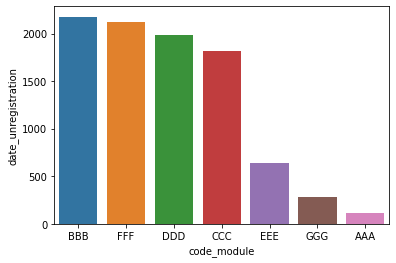

In [55]:
# Построим график
sns.barplot(x='code_module', y ='date_unregistration', data = unregistration)

In [56]:
# Топ-3 предметов по количеству оттока на них
unregistration.iloc[0:3]

,code_module,date_unregistration
1,BBB,2176
5,FFF,2123
3,DDD,1980


<h4> В топ-3 предметов по количеству оттока входят - BBB, FFF, DDD

In [57]:
registration = std_registr_df.query("date_registration != 0.0")\
    .groupby('code_module', as_index=False).agg({'id_student': 'nunique'})\
    .rename(columns={'id_student': 'date_registration'})\
    .sort_values(by='date_registration', ascending=False)
registration

,code_module,date_registration
1,BBB,7683
5,FFF,7387
3,DDD,5840
2,CCC,4244
4,EEE,2857
6,GGG,2524
0,AAA,712


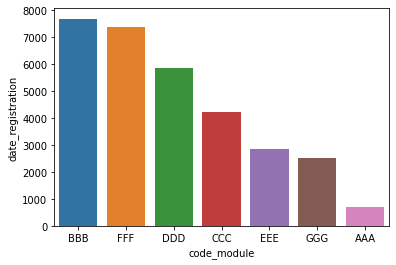

In [58]:
# Построим график
sns.barplot(x='code_module', y='date_registration', data = registration)

In [59]:
# Топ-3 предметов по количеству регистраций на них
registration.iloc[0:3]

,code_module,date_registration
1,BBB,7683
5,FFF,7387
3,DDD,5840


<h4> В топ-3 предметов по количеству регистраций входят - BBB, FFF, DDD

<h3>V. Выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов

In [60]:
# В таблице course_results найдем количество всех попыток сдать экзамены с разбивкой по айди экзамена
total_passed_exams = course_results.query("assessment_type == 'Exam'")\
    .groupby(['id_assessment', 'code_presentation', 'date'], as_index=False)\
    .agg({'score': 'count'})

In [61]:
total_passed_exams = total_passed_exams.rename(columns={'score': 'total_amount_of_passed'})

In [62]:
total_passed_exams

,id_assessment,code_presentation,date,total_amount_of_passed
0,25340,2013B,240.0,602
1,25354,2013J,261.0,968
2,25361,2014B,241.0,524
3,30713,2013J,235.0,0
4,30718,2014B,228.0,0
5,30723,2014J,235.0,0
6,34872,2013B,222.0,0
7,34885,2013J,236.0,0
8,34898,2014B,227.0,0
9,34911,2014J,241.0,0


In [63]:
# В таблице  course_results найдем количество успешных попыток сдать экзамены. Успешные попытки – это балл выше 40
cool_passed_exams = course_results.query("assessment_type == 'Exam' and score>=40.0")\
    .groupby(['id_assessment', 'code_presentation', 'date'], as_index=False)\
    .agg({'score': 'count'})

In [64]:
cool_passed_exams = cool_passed_exams.rename(columns={'score': 'amount_of_cool_passed'})

In [65]:
cool_passed_exams

,id_assessment,code_presentation,date,amount_of_cool_passed
0,25340,2013B,240.0,504
1,25354,2013J,261.0,878
2,25361,2014B,241.0,485


In [66]:
# Объединим данные cool_passed_exams и total_passed_exams, 
# чтобы получить данные по всем сдачам и успешным сдачам экзамена
total_passed = total_passed_exams.merge(cool_passed_exams, how='inner', on='id_assessment')

In [67]:
total_passed

,id_assessment,code_presentation_x,date_x,total_amount_of_passed,code_presentation_y,date_y,amount_of_cool_passed
0,25340,2013B,240.0,602,2013B,240.0,504
1,25354,2013J,261.0,968,2013J,261.0,878
2,25361,2014B,241.0,524,2014B,241.0,485


In [68]:
# В данную таблицу добавим  столбец, где считаем завершаемость
total_passed['end'] = (total_passed['amount_of_cool_passed']/total_passed['total_amount_of_passed']*100).round(2)

In [69]:
total_passed = total_passed.drop(columns=['code_presentation_x', 'date_x'])

In [70]:
# Получили таблицу с завершаемостями курсов
total_passed

,id_assessment,total_amount_of_passed,code_presentation_y,date_y,amount_of_cool_passed,end
0,25340,602,2013B,240.0,504,83.72
1,25354,968,2013J,261.0,878,90.70
2,25361,524,2014B,241.0,485,92.56


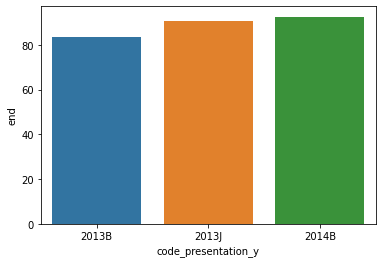

In [71]:
# Построим график
sns.barplot(x='code_presentation_y', y='end', data = total_passed)

<h4> Таким образом, семестр с самой низкой завершаемостью курсов - 2013B

In [72]:
well_done = welldone_exams_course_results.fillna(0)

In [73]:
well_done.groupby('code_presentation', as_index=False)\
    .agg({'date_submitted': 'mean'})\
    .sort_values(by='date_submitted', ascending=False)

,code_presentation,date_submitted
3,2014J,243.680279
1,2013J,239.509112
2,2014B,232.997389
0,2013B,230.164683


<h4>Таким образом, семестром с самыми долгими средними сроками сдачи курсов является 2014J

<h3> VI. Построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию

В адаптированной кластеризации можешь выбрать следующие метрики:
- R - среднее время сдачи одного экзамена, 
- F - завершаемость курсов, 
- M - среднее количество баллов, получаемое за экзамен.  

Подробно опиши, как ты создавал кластеры.  
Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

<h4> 1. Найдем M - среднее количество баллов, получаемое за экзамен

In [74]:
# Возьмем за основу ранее полученную таблицу course_results с результатами курса по каждому студенту 
# и отберем значения только за экзамены
course_results

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,AAA,2013J,1752,TMA,19.0,10.0,11391.0,18.0,0.0,78.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400.0,22.0,0.0,70.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604.0,17.0,0.0,72.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885.0,26.0,0.0,69.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053.0,19.0,0.0,79.0
...,...,...,...,...,...,...,...,...,...,...
173925,GGG,2014J,37437,TMA,173.0,0.0,652539.0,176.0,0.0,75.0
173926,GGG,2014J,37437,TMA,173.0,0.0,653157.0,187.0,0.0,70.0
173927,GGG,2014J,37437,TMA,173.0,0.0,653252.0,171.0,0.0,70.0
173928,GGG,2014J,37437,TMA,173.0,0.0,653374.0,172.0,0.0,50.0


In [75]:
# Найдем средний балл для каждого студента только за экзамены
M = course_results.query("assessment_type == 'Exam'")\
    .groupby('id_student', as_index=False)\
    .agg({'score': 'mean'})\
    .rename(columns={'score': 'monetary'})\
    .round(2)
M = M.fillna(0)
M.sort_values('monetary')

,id_student,monetary
75,81351.0,0.0
137,131152.0,0.0
1736,556660.0,0.0
4529,2588543.0,4.0
492,338034.0,7.0
...,...,...
3616,654002.0,100.0
2911,619870.0,100.0
456,325044.0,100.0
1657,552441.0,100.0


<h4> 2. Найдем R - среднее время сдачи одного экзамена

In [76]:
R = course_results.query("assessment_type == 'Exam'")\
    .groupby('id_student', as_index=False)\
    .agg({'date_submitted': 'mean'})\
    .rename(columns={'date_submitted': 'recency'})\
    .sort_values('recency')\
    .round(0)\
    .fillna(0)
R

,id_student,recency
666,391185.0,229.0
473,333856.0,229.0
1249,512080.0,229.0
4242,1982845.0,229.0
4070,957467.0,229.0
...,...,...
4037,695916.0,256.0
532,352637.0,259.0
1704,555008.0,266.0
4374,2341830.0,279.0


<h4> 3. Найдем F - завершаемость курсов

In [77]:
course_results

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,AAA,2013J,1752,TMA,19.0,10.0,11391.0,18.0,0.0,78.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400.0,22.0,0.0,70.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604.0,17.0,0.0,72.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885.0,26.0,0.0,69.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053.0,19.0,0.0,79.0
...,...,...,...,...,...,...,...,...,...,...
173925,GGG,2014J,37437,TMA,173.0,0.0,652539.0,176.0,0.0,75.0
173926,GGG,2014J,37437,TMA,173.0,0.0,653157.0,187.0,0.0,70.0
173927,GGG,2014J,37437,TMA,173.0,0.0,653252.0,171.0,0.0,70.0
173928,GGG,2014J,37437,TMA,173.0,0.0,653374.0,172.0,0.0,50.0


In [78]:
# Найдем количество всех попыток сдать экзамен с разбивкой по id студента
df_total = course_results.query("assessment_type == 'Exam'")\
    .groupby('id_student', as_index=False)\
    .agg({'score': 'count'})\
    .rename(columns={'score': 'total_try'})
df_total

,id_student,total_try
0,23698.0,1
1,24213.0,1
2,27116.0,1
3,28046.0,1
4,28787.0,1
...,...,...
4628,2694886.0,1
4629,2694933.0,1
4630,2695608.0,1
4631,2697181.0,1


In [79]:
# Найдем количество успешных попыток сдать экзамен с разбивкой по id студента
cool_df = course_results.query("assessment_type == 'Exam' & score>=40.0")\
    .groupby('id_student', as_index=False)\
    .agg({'score': 'count'})\
    .rename(columns={'score': 'cool_try'})
cool_df

,id_student,cool_try
0,23698.0,1
1,24213.0,1
2,27116.0,1
3,28046.0,1
4,28787.0,1
...,...,...
4092,2694886.0,1
4093,2694933.0,1
4094,2695608.0,1
4095,2697181.0,1


In [80]:
# Объединим таблицы
df_total_cool = df_total.merge(cool_df, on='id_student')
df_total_cool

,id_student,total_try,cool_try
0,23698.0,1,1
1,24213.0,1,1
2,27116.0,1,1
3,28046.0,1,1
4,28787.0,1,1
...,...,...,...
4092,2694886.0,1,1
4093,2694933.0,1,1
4094,2695608.0,1,1
4095,2697181.0,1,1


In [81]:
# Найдем завершаемость
df_total_cool['end'] = (df_total_cool['cool_try']/df_total_cool['total_try']*100).round(2)
df_total_cool = df_total_cool.rename(columns={'end':'frequency'})
F = df_total_cool
F

,id_student,total_try,cool_try,frequency
0,23698.0,1,1,100.0
1,24213.0,1,1,100.0
2,27116.0,1,1,100.0
3,28046.0,1,1,100.0
4,28787.0,1,1,100.0
...,...,...,...,...
4092,2694886.0,1,1,100.0
4093,2694933.0,1,1,100.0
4094,2695608.0,1,1,100.0
4095,2697181.0,1,1,100.0


Соединим таблицы:
- M - значения monetary
- R - значения recency
- F - значения frequency

In [82]:
MR = M.merge(R, on='id_student')
MR

,id_student,monetary,recency
0,23698.0,80.0,243.0
1,24213.0,58.0,236.0
2,27116.0,96.0,243.0
3,28046.0,40.0,237.0
4,28787.0,44.0,243.0
...,...,...,...
4628,2694886.0,69.0,236.0
4629,2694933.0,73.0,230.0
4630,2695608.0,73.0,237.0
4631,2697181.0,80.0,230.0


In [83]:
RFM = MR.merge(F, on='id_student').drop(columns=['total_try', 'cool_try'])
RFM

,id_student,monetary,recency,frequency
0,23698.0,80.0,243.0,100.0
1,24213.0,58.0,236.0,100.0
2,27116.0,96.0,243.0,100.0
3,28046.0,40.0,237.0,100.0
4,28787.0,44.0,243.0,100.0
...,...,...,...,...
4092,2694886.0,69.0,236.0,100.0
4093,2694933.0,73.0,230.0,100.0
4094,2695608.0,73.0,237.0,100.0
4095,2697181.0,80.0,230.0,100.0


Поработаем с показателем RFM. Для его расчета будем использовать квантили — составление четырех равных частей на основе доступных значений

In [84]:
quantiles = RFM.quantile(q=[0.25,0.5,0.75])
quantiles

,id_student,monetary,recency,frequency
0.25,504429.0,56.0,234.0,100.0
0.50,592093.0,69.0,241.0,100.0
0.75,648841.0,84.0,243.0,100.0


In [85]:
# Сконвертируем квантили в словарь, чтобы было легче работать
quantiles = quantiles.to_dict()

In [86]:
# RFM Segmentation
RFM_Segment = RFM.copy()
RFM_Segment

,id_student,monetary,recency,frequency
0,23698.0,80.0,243.0,100.0
1,24213.0,58.0,236.0,100.0
2,27116.0,96.0,243.0,100.0
3,28046.0,40.0,237.0,100.0
4,28787.0,44.0,243.0,100.0
...,...,...,...,...
4092,2694886.0,69.0,236.0,100.0
4093,2694933.0,73.0,230.0,100.0
4094,2695608.0,73.0,237.0,100.0
4095,2697181.0,80.0,230.0,100.0


Присвоим ранги. Чем меньше значение Recency, тем лучше. Чем больше значения Frequency и Monetary тем лучше. Всего пусть будет 4 ранга

In [87]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [88]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [89]:
RFM_Segment['R_Quartile'] = RFM_Segment['recency'].apply(R_Class, args=('recency', quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency', quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['monetary'].apply(FM_Class, args=('monetary', quantiles,))
RFM_Segment['RFMClass']   = RFM_Segment.R_Quartile.map(str)\
                          + RFM_Segment.F_Quartile.map(str)\
                          + RFM_Segment.M_Quartile.map(str)

In [90]:
RFM_Segment

,id_student,monetary,recency,frequency,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,23698.0,80.0,243.0,100.0,2,1,3,213
1,24213.0,58.0,236.0,100.0,3,1,2,312
2,27116.0,96.0,243.0,100.0,2,1,4,214
3,28046.0,40.0,237.0,100.0,3,1,1,311
4,28787.0,44.0,243.0,100.0,2,1,1,211
...,...,...,...,...,...,...,...,...
4092,2694886.0,69.0,236.0,100.0,3,1,2,312
4093,2694933.0,73.0,230.0,100.0,4,1,3,413
4094,2695608.0,73.0,237.0,100.0,3,1,3,313
4095,2697181.0,80.0,230.0,100.0,4,1,3,413


In [91]:
# Получили таблицу с кластерами и количеством студентов, входящих в каждый кластер
clasters = RFM_Segment.groupby('RFMClass', as_index=False)\
    .agg({'id_student': 'count'})\
    .sort_values('id_student')\
    .rename(columns={'id_student': 'amount_of_student'})
clasters.sort_values('amount_of_student', ascending=False)

,RFMClass,amount_of_student
12,411,382
14,413,353
5,212,308
4,211,301
6,213,299
13,412,294
3,114,275
15,414,274
10,313,254
8,311,224


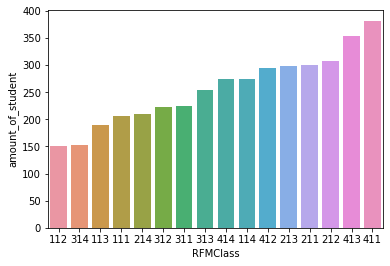

In [92]:
# Построим график
sns.barplot(x='RFMClass', y='amount_of_student', data = clasters)

Согласно рассчитанным данным и графику, наибольшее количество студентов (382) имеют индекс 411, где R = 4, F = 1, M = 1, что значит, что экзамен сдан быстро, курс завершен и качественно (то есть баллы высокие). В свою очередь, наименьшее количество студентов (151) имеют индекс 112, где R = 1, F = 1, M = 2, что значит, что экзамен они сдавали долго, получили низкие баллы и курс не завершили. 

- R - среднее время сдачи одного экзамена,
- F - завершаемость курсов,
- M - среднее количество баллов, получаемое за экзамен.